# Índice

#### 1. [Introdução](#1)
#### 2. [Inicialização e funções auxiliares](#2)
#### 3. [PCA](#3)
#### 4. [Pré-poda e pós-poda](#4)
#### 5. [Outros ajustes](#5)
#### 6. [Conclusão](#6)

## 1. Introdução<a name="1"></a>

Vamos continuar a trabalhar com os dados de cancelamentos de agendamentos de estadias em dois hotéis de uma empresa em Portugal.

Fizemos anteriormente a análise inicial dos dados e um primeiro modelo utilizando Árvores de Decisão, que otimizamos até atingirmos as seguintes estatísticas:

- Acurácia na base de treino: 81.53%
    - Modelo previu cancelado, mas é não cancelado: 17.47%
    - Modelo previu não cancelado, e é não cancelado: 82.53%
    - Modelo previu não cancelado, mas é cancelado: 20.17%
    - Modelo previu cancelado, e é cancelado: 79.83%
- Acurácia na base de teste: 81.28%
    - Modelo previu cancelado, mas é não cancelado: 17.21%
    - Modelo previu não cancelado, e é não cancelado: 82.79%
    - Modelo previu não cancelado, mas é cancelado: 21.27%
    - Modelo previu cancelado, e é cancelado: 78.73%
 
Neste caderno vamos continuar trabalhando com esses dados, mas buscando melhorar o modelo utilizando técnicas de PCA.

- O resumo do trabalho pode ser acessado aqui: [resumo do trabalho](https://github.com/luckssm/hotel-booking/blob/main/relatorio_hotel_booking.pdf)
- O caderno anterior (Árvores de Decisão) pode ser acessado aqui: [caderno Árvores de Decisão](https://github.com/luckssm/hotel-booking/blob/main/hotel_booking_decision_tree.ipynb)
- O próximo caderno (SVM) pode ser acessado aqui: [caderno SVM](https://github.com/luckssm/hotel-booking/blob/main/hotel_booking_svm.ipynb)
- A base original pode ser acessada aqui: https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand

Vamos continuar utilizando a base trabalhada anteriormente, que possui os campos: 

| Variável | Tipo | Descrição |
| -------- | ---- | --------- |
| hotel                          |  object  | Hotel (H1 = Resort Hotel or H2 = City Hotel) |
| is_canceled                    |  int64   | Value indicating if the booking was canceled (1) or not (0) |
| lead_time                      |  int64   | Number of days that elapsed between the entering date of the booking into the PMS and the arrival date |
| arrival_date_year              |  int64   | Year of arrival date |
| arrival_date_month             |  object  | Month of arrival date (1 - January, 2 - February...) |
| arrival_date_week_number       |  int64   | Week number of year for arrival date |
| arrival_date_day_of_month      |  int64   | Day of arrival date |
| stays_in_weekend_nights        |  int64   | Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel |
| stays_in_week_nights           |  int64   | Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel |
| adults                         |  int64   | Number of adults |
| children                       |  float64 | Number of children |
| babies                         |  int64   | Number of babies |
| meal                           |  object  | Type of meal booked. Categories are presented in standard hospitality meal packages: Undefined/SC – no meal package; BB – Bed & Breakfast; HB – Half board (breakfast and one other meal – usually dinner); FB – Full board (breakfast, lunch and dinner) |
| market_segment                 |  object  | Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators” |
| distribution_channel           |  object  | Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators” |
| is_repeated_guest              |  int64   | Value indicating if the booking name was from a repeated guest (1) or not (0) |
| previous_cancellations         |  int64   | Number of previous bookings that were cancelled by the customer prior to the current booking |
| previous_bookings_not_canceled |  int64   | Number of previous bookings not cancelled by the customer prior to the current booking |
| reserved_room_type             |  object  | Code of room type reserved. Code is presented instead of designation for anonymity reasons. |
| assigned_room_type             |  object  | Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons. |
| booking_changes                |  int64   | Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation |
| deposit_type                   |  object  | Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories: No Deposit – no deposit was made; Non Refund – a deposit was made in the value of the total stay cost; Refundable – a deposit was made with a value under the total cost of stay. |
| agent                          |  float64 | ID of the travel agency that made the booking  |
| company                        |  float64 | ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons |
| days_in_waiting_list           |  int64   | Number of days the booking was in the waiting list before it was confirmed to the customer |
| customer_type                  |  object  | Type of booking, assuming one of four categories: Contract - when the booking has an allotment or other type of contract associated to it; Group – when the booking is associated to a group; Transient – when the booking is not part of a group or contract, and is not associated to other transient booking; Transient-party – when the booking is transient, but is associated to at least other transient booking |
| adr                            |  float64 | Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights |
| required_car_parking_spaces    |  int64   | Number of car parking spaces required by the customer |
| total_of_special_requests      |  int64   | Number of special requests made by the customer (e.g. twin bed or high floor) |

## 2. Inicialização e funções auxiliares<a name="2"></a> 

Importações:

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA

from tqdm import tqdm

Leitura do arquivo:

In [2]:
main = pd.read_csv('hotel_bookings_cleaned.csv')
main

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,reserved_room_type,assigned_room_type,booking_changes,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,342,2015,7,27,1,0,0,2,...,3,3,3,-1.0,-1.0,0,Transient,0.00,0,0
1,Resort Hotel,0,737,2015,7,27,1,0,0,2,...,3,3,4,-1.0,-1.0,0,Transient,0.00,0,0
2,Resort Hotel,0,7,2015,7,27,1,0,1,1,...,1,3,0,-1.0,-1.0,0,Transient,75.00,0,0
3,Resort Hotel,0,13,2015,7,27,1,0,1,1,...,1,1,0,304.0,-1.0,0,Transient,75.00,0,0
4,Resort Hotel,0,14,2015,7,27,1,0,2,2,...,1,1,0,240.0,-1.0,0,Transient,98.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,8,35,30,2,5,2,...,1,1,0,394.0,-1.0,0,Transient,96.14,0,0
119386,City Hotel,0,102,2017,8,35,31,2,5,3,...,5,5,0,9.0,-1.0,0,Transient,225.43,0,2
119387,City Hotel,0,34,2017,8,35,31,2,5,2,...,4,4,0,9.0,-1.0,0,Transient,157.71,0,4
119388,City Hotel,0,109,2017,8,35,31,2,5,2,...,1,1,0,89.0,-1.0,0,Transient,104.40,0,0


Vamos obter as variáveis dummies:

In [3]:
main_dummies = pd.get_dummies(main)
main_dummies

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,market_segment_Undefined,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,342,2015,7,27,1,0,0,2,0.0,...,False,False,True,False,False,False,False,False,True,False
1,0,737,2015,7,27,1,0,0,2,0.0,...,False,False,True,False,False,False,False,False,True,False
2,0,7,2015,7,27,1,0,1,1,0.0,...,False,False,True,False,False,False,False,False,True,False
3,0,13,2015,7,27,1,0,1,1,0.0,...,False,True,False,False,False,False,False,False,True,False
4,0,14,2015,7,27,1,0,2,2,0.0,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,23,2017,8,35,30,2,5,2,0.0,...,False,False,False,False,True,False,False,False,True,False
119386,0,102,2017,8,35,31,2,5,3,0.0,...,False,False,False,False,True,False,False,False,True,False
119387,0,34,2017,8,35,31,2,5,2,0.0,...,False,False,False,False,True,False,False,False,True,False
119388,0,109,2017,8,35,31,2,5,2,0.0,...,False,False,False,False,True,False,False,False,True,False


E dividir nossa base em teste, treino e validação:

In [4]:
X = main_dummies.drop('is_canceled', axis=1)
y = main_dummies.is_canceled

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7412395)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.3, random_state=7412395)

Vamos primeiro criar uma função auxiliar para calcular a acurácia dos nossos modelos:

In [5]:
# Plots confusion matrix
def plot_confusion_matrix(cm):
    MatrixDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                           display_labels=['Não cancelado', 'Cancelado']
                                          )
    MatrixDisplay.plot(cmap=plt.cm.Blues,values_format='g')
    plt.show()

# Calculates the confusion matrix
def calculate_confusion_matrix(y_true, y_pred, type, show_acc=False, plot_matrix=False):
    cm = confusion_matrix(y_true, y_pred)
    tab = pd.crosstab(index = y_true, columns = y_pred)
    
    # Predicted canceled, but is not canceled
    false_positive_acc = (tab.iloc[0, 1] / (tab.iloc[0, 1] + tab.iloc[0, 0])) * 100
    
    # Predicted not canceled, and is not canceled
    true_negative_acc = (tab.iloc[0, 0] / (tab.iloc[0, 1] + tab.iloc[0, 0])) * 100
    
    # Predicted not canceled, and is canceled
    false_negative_acc = (tab.iloc[1, 0] / (tab.iloc[1, 1] + tab.iloc[1, 0])) * 100
    
    # Predicted canceled, and is canceled
    true_positive_acc = (tab.iloc[1, 1] / (tab.iloc[1, 1] + tab.iloc[1, 0])) * 100

    if show_acc:
        print(f'Acurácias de {type}:')
        print(f'Modelo previu cancelado, mas é não cancelado: {false_positive_acc:.2f}%')
        print(f'Modelo previu não cancelado, e é não cancelado: {true_negative_acc:.2f}%')
        print(f'Modelo previu não cancelado, mas é cancelado: {false_negative_acc:.2f}%')
        print(f'Modelo previu cancelado, e é cancelado: {true_positive_acc:.2f}%')
    
    if plot_matrix:
        plot_confusion_matrix(cm)
        
    return [true_negative_acc, true_positive_acc]
        

# Calculates accuracy of model based on train and test bases and shows confusion matrix if wanted
def calculate_model_acc_score(model, x_train, y_train, x_test, y_test, show_confusion_matrix=False, show_acc=False):
    y_pred_train = model.predict(x_train)
    acc_train = accuracy_score(y_train, y_pred_train)*100
    
    y_pred_test = model.predict(x_test)
    acc_test = accuracy_score(y_test, y_pred_test)*100

    if show_acc:
        print('Acurácia na base de treino: {0:.2f}%'.format(acc_train)) 
        print('Acurácia na base de teste: {0:.2f}%'.format(acc_test))
        print('\n')
    
    accuracies = [acc_train, acc_test]
    train_acc_matrix = calculate_confusion_matrix(y_train, y_pred_train, type='treino', show_acc=show_acc, plot_matrix=show_confusion_matrix)
    test_acc_matrix = calculate_confusion_matrix(y_test, y_pred_test, type='teste', show_acc=show_acc, plot_matrix=show_confusion_matrix)
    accuracies = accuracies + train_acc_matrix + test_acc_matrix

    return accuracies
    

Vamos definir uma função para treinar uma árvore utilizando a técnica PCA passando o número de componentes por parâmetro:

In [6]:
# Trains a tree with number of components passed by param
def train_tree_with_pca(n_components, x_train, x_validation, x_test, y_train, y_validation, y_test, random_state, show_accuracy=False, plot_matrix=False):
    prcomp = PCA(n_components=n_components, random_state=random_state).fit(x_train)
    
    pc_train_pre = prcomp.transform(x_train)
    pc_validation_pre = prcomp.transform(x_validation)
    pc_test_pre  = prcomp.transform(x_test)
    
    n=n_components
    
    columns = ['cp'+str(x+1) for x in list(range(n))]
    
    pc_train = pd.DataFrame(pc_train_pre[:,:n], columns = columns)
    pc_validation = pd.DataFrame(pc_validation_pre[:,:n], columns = columns)
    pc_test  = pd.DataFrame(pc_test_pre[:,:n], columns = columns)
    
    # params = {'max_depth': [10,14,18,22,26],
    #          'min_samples_split': [2,3,4,5,6],
    #          'min_samples_leaf': [1,2,3,4,5]}
    
    clf = DecisionTreeClassifier(random_state=random_state)
    clf.fit(pc_train, y_train)
    # gcv = GridSearchCV(estimator=clf,param_grid=params)
    # gcv.fit(pc_train,y_train)
    
    stats_list = [n_components]
    if plot_matrix or show_accuracy:
        print(f'Modelo com {n_components} componentes:\n')
        
    accuracies = calculate_model_acc_score(clf, pc_train, y_train, pc_validation, y_validation, show_confusion_matrix=plot_matrix, show_acc=show_accuracy)
    stats_list = stats_list + accuracies
    
    return stats_list

## 3. PCA<a name="3"></a> 

Agora vamos criar modelos com diferentes componentes, entre 5 e 35, pulando de 5 em 5, para encontrarmos a melhor quantidade de componentes para nosso caso.

Modelo com 5 componentes:

Acurácia na base de treino: 99.26%
Acurácia na base de teste: 76.31%


Acurácias de treino:
Modelo previu cancelado, mas é não cancelado: 0.33%
Modelo previu não cancelado, e é não cancelado: 99.67%
Modelo previu não cancelado, mas é cancelado: 1.44%
Modelo previu cancelado, e é cancelado: 98.56%


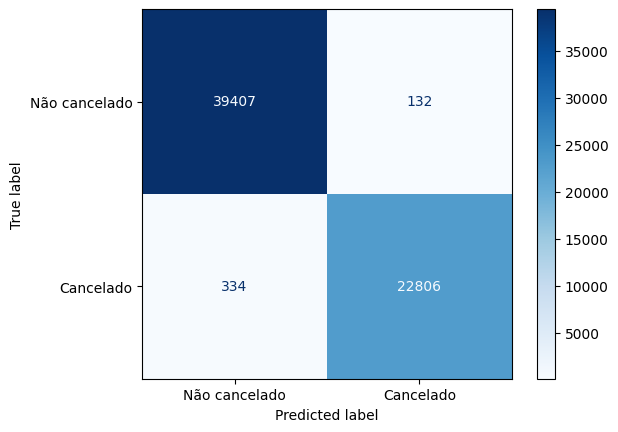

Acurácias de teste:
Modelo previu cancelado, mas é não cancelado: 19.56%
Modelo previu não cancelado, e é não cancelado: 80.44%
Modelo previu não cancelado, mas é cancelado: 30.66%
Modelo previu cancelado, e é cancelado: 69.34%


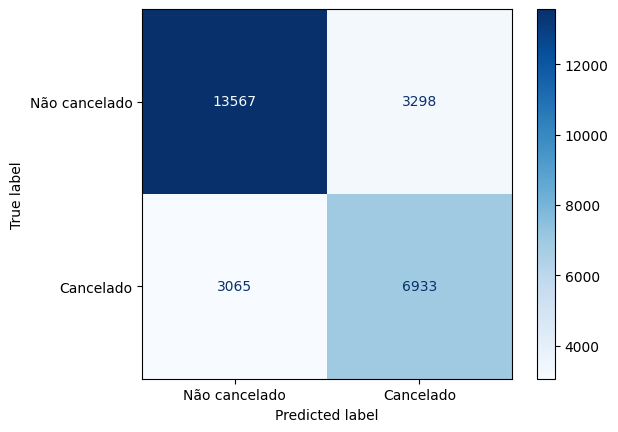

Modelo com 10 componentes:

Acurácia na base de treino: 99.26%
Acurácia na base de teste: 77.46%


Acurácias de treino:
Modelo previu cancelado, mas é não cancelado: 0.33%
Modelo previu não cancelado, e é não cancelado: 99.67%
Modelo previu não cancelado, mas é cancelado: 1.44%
Modelo previu cancelado, e é cancelado: 98.56%


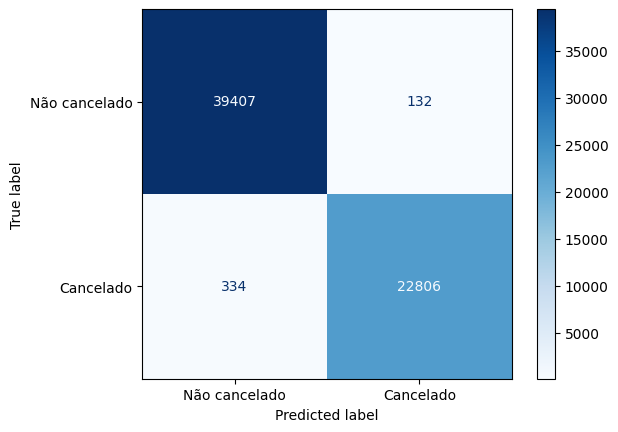

Acurácias de teste:
Modelo previu cancelado, mas é não cancelado: 18.46%
Modelo previu não cancelado, e é não cancelado: 81.54%
Modelo previu não cancelado, mas é cancelado: 29.43%
Modelo previu cancelado, e é cancelado: 70.57%


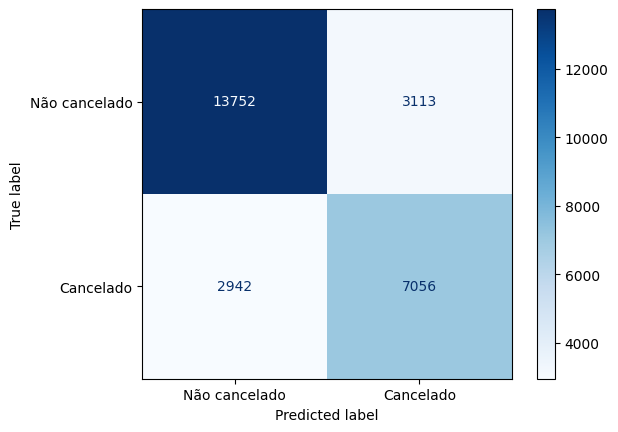

Modelo com 15 componentes:

Acurácia na base de treino: 99.26%
Acurácia na base de teste: 79.42%


Acurácias de treino:
Modelo previu cancelado, mas é não cancelado: 0.33%
Modelo previu não cancelado, e é não cancelado: 99.67%
Modelo previu não cancelado, mas é cancelado: 1.44%
Modelo previu cancelado, e é cancelado: 98.56%


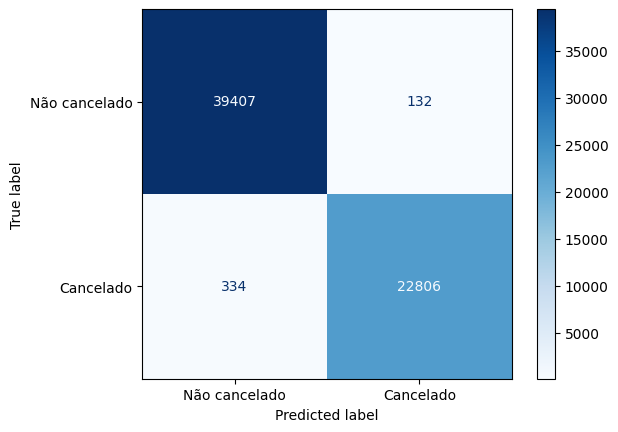

Acurácias de teste:
Modelo previu cancelado, mas é não cancelado: 16.88%
Modelo previu não cancelado, e é não cancelado: 83.12%
Modelo previu não cancelado, mas é cancelado: 26.84%
Modelo previu cancelado, e é cancelado: 73.16%


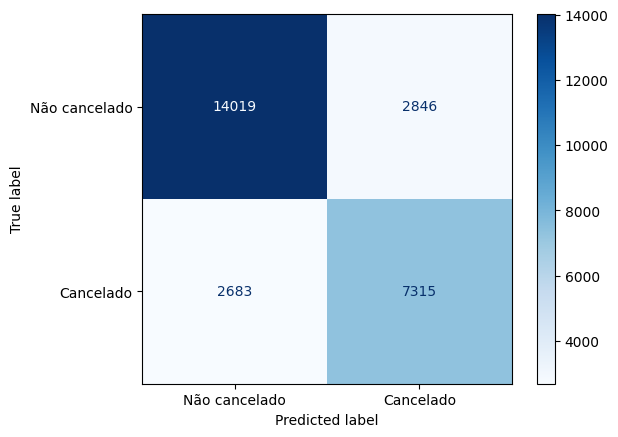

Modelo com 20 componentes:

Acurácia na base de treino: 99.26%
Acurácia na base de teste: 79.76%


Acurácias de treino:
Modelo previu cancelado, mas é não cancelado: 0.33%
Modelo previu não cancelado, e é não cancelado: 99.67%
Modelo previu não cancelado, mas é cancelado: 1.44%
Modelo previu cancelado, e é cancelado: 98.56%


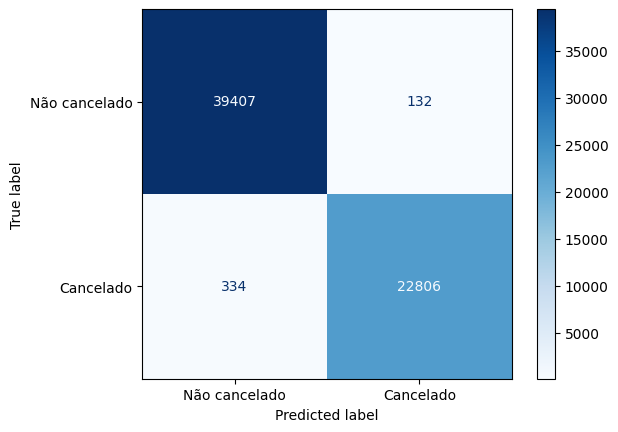

Acurácias de teste:
Modelo previu cancelado, mas é não cancelado: 16.95%
Modelo previu não cancelado, e é não cancelado: 83.05%
Modelo previu não cancelado, mas é cancelado: 25.78%
Modelo previu cancelado, e é cancelado: 74.22%


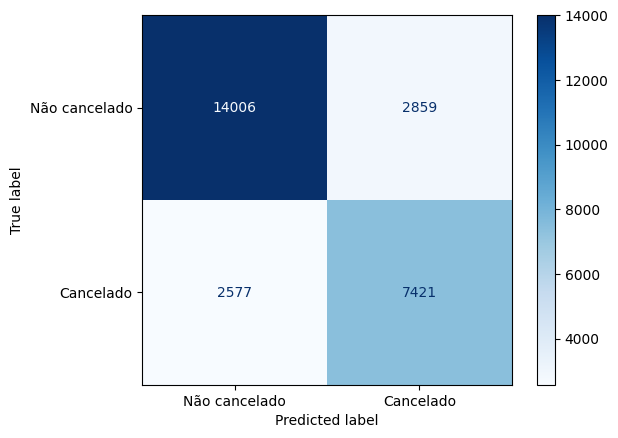

Modelo com 25 componentes:

Acurácia na base de treino: 99.26%
Acurácia na base de teste: 79.98%


Acurácias de treino:
Modelo previu cancelado, mas é não cancelado: 0.33%
Modelo previu não cancelado, e é não cancelado: 99.67%
Modelo previu não cancelado, mas é cancelado: 1.44%
Modelo previu cancelado, e é cancelado: 98.56%


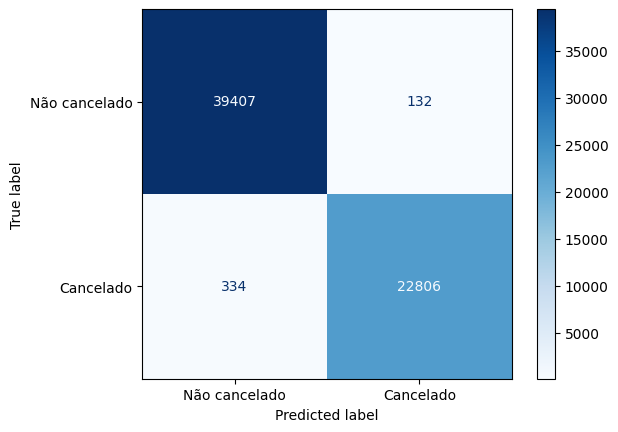

Acurácias de teste:
Modelo previu cancelado, mas é não cancelado: 16.43%
Modelo previu não cancelado, e é não cancelado: 83.57%
Modelo previu não cancelado, mas é cancelado: 26.09%
Modelo previu cancelado, e é cancelado: 73.91%


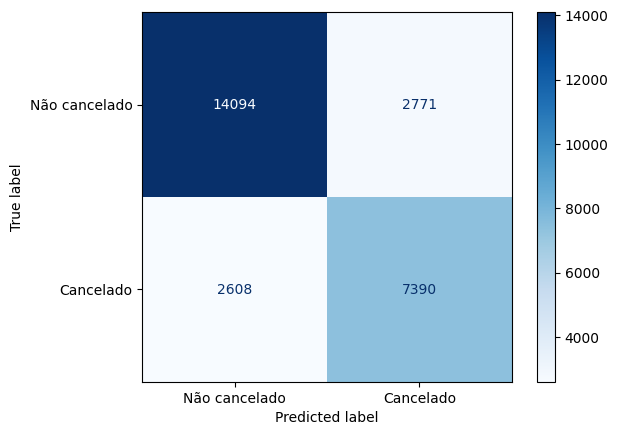

Modelo com 30 componentes:

Acurácia na base de treino: 99.26%
Acurácia na base de teste: 80.68%


Acurácias de treino:
Modelo previu cancelado, mas é não cancelado: 0.33%
Modelo previu não cancelado, e é não cancelado: 99.67%
Modelo previu não cancelado, mas é cancelado: 1.44%
Modelo previu cancelado, e é cancelado: 98.56%


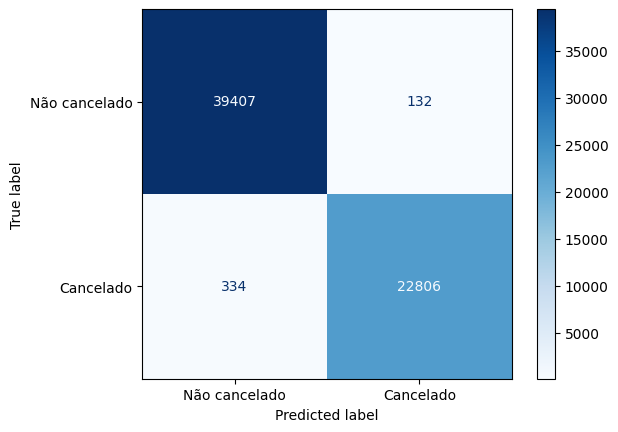

Acurácias de teste:
Modelo previu cancelado, mas é não cancelado: 15.71%
Modelo previu não cancelado, e é não cancelado: 84.29%
Modelo previu não cancelado, mas é cancelado: 25.41%
Modelo previu cancelado, e é cancelado: 74.59%


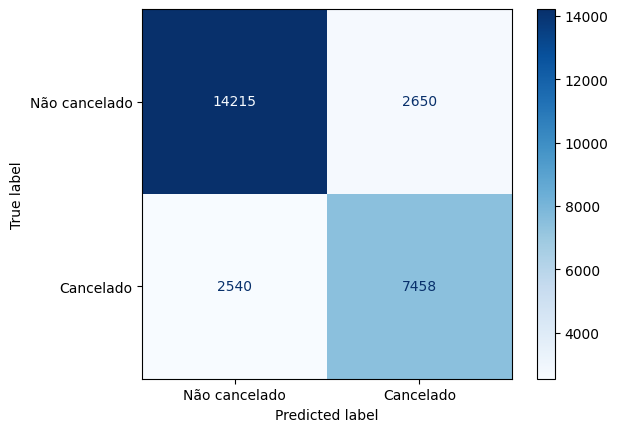

Modelo com 35 componentes:

Acurácia na base de treino: 99.26%
Acurácia na base de teste: 80.61%


Acurácias de treino:
Modelo previu cancelado, mas é não cancelado: 0.33%
Modelo previu não cancelado, e é não cancelado: 99.67%
Modelo previu não cancelado, mas é cancelado: 1.44%
Modelo previu cancelado, e é cancelado: 98.56%


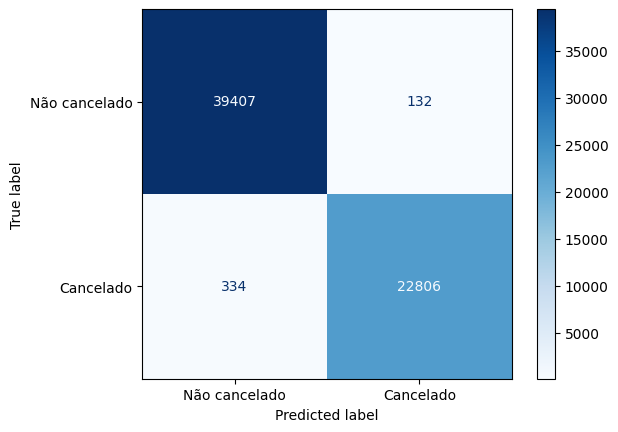

Acurácias de teste:
Modelo previu cancelado, mas é não cancelado: 15.97%
Modelo previu não cancelado, e é não cancelado: 84.03%
Modelo previu não cancelado, mas é cancelado: 25.16%
Modelo previu cancelado, e é cancelado: 74.84%


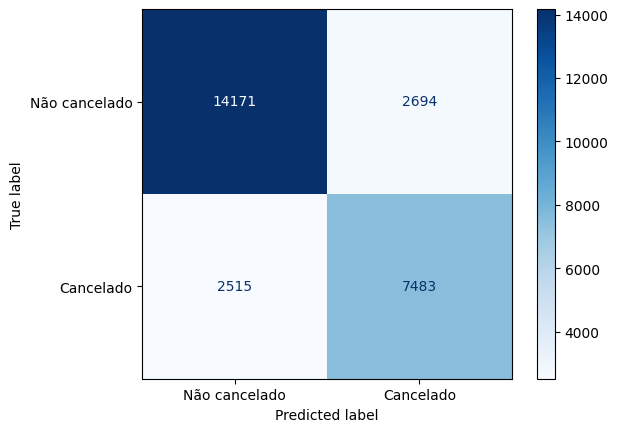

CPU times: user 37.3 s, sys: 2.4 s, total: 39.7 s
Wall time: 19.9 s


In [11]:
%%time
stats_list = []
for n_components in range(5, 36, 5):
    stats = train_tree_with_pca(
        n_components, 
        x_train, 
        x_validation, 
        x_test, 
        y_train, 
        y_validation, 
        y_test, 
        random_state=7412395, 
        show_accuracy=True, 
        plot_matrix=True
    )
    stats_list.append(stats)

stats_df = pd.DataFrame(stats_list, columns=[
    'n_components', 
    'train_acc', 
    'validation_acc',
    'train_true_negative_acc', 
    'train_true_positive_acc', 
    'valid_true_negative_acc',
    'valid_true_positive_acc'
])

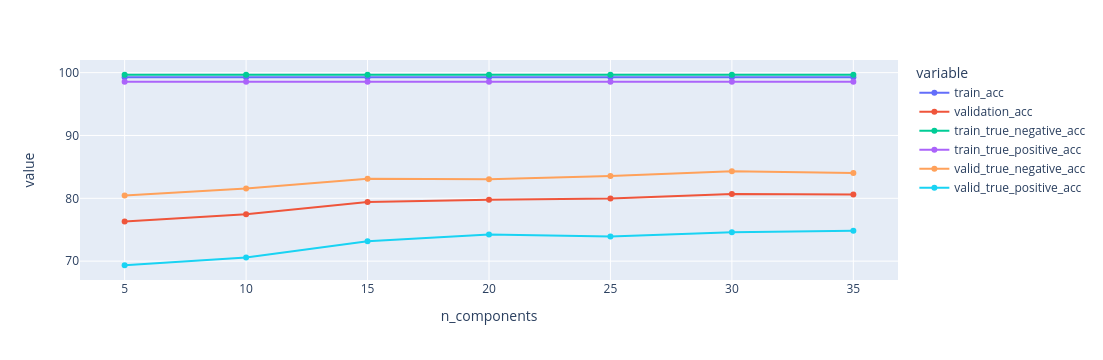

In [12]:
px.line(
    x='n_components', 
    y=[
        'n_components', 
        'train_acc', 
        'validation_acc', 
        'train_true_negative_acc', 
        'train_true_positive_acc', 
        'valid_true_negative_acc',
        'valid_true_positive_acc'
    ], 
    data_frame=stats_df, 
    markers=True
)

Vemos que entre 15 e 35 componentes temos acurácias de validação interessantes tanto gerais e de verdadeiro negativo, quanto de verdadeiro positivo.

Vamos calcular novamente as acurácias para um número entre 15 e 35 componentes:

100%|██████████| 21/21 [01:06<00:00,  3.17s/it]

CPU times: user 2min 1s, sys: 7.47 s, total: 2min 9s
Wall time: 1min 6s


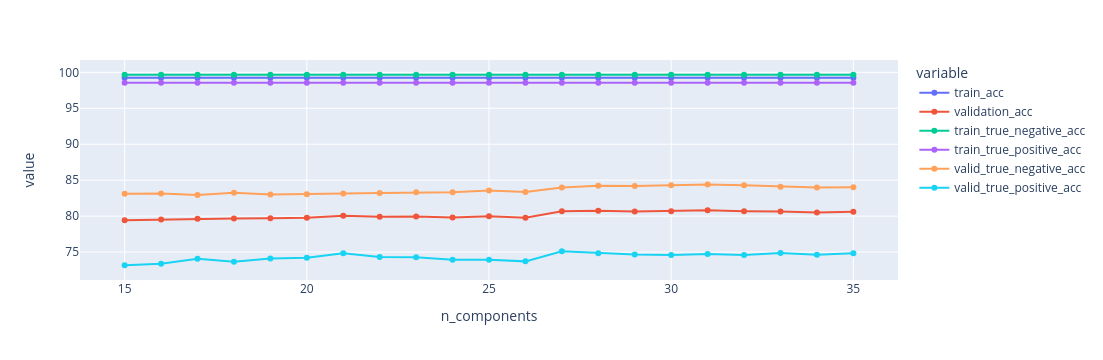

In [13]:
%%time
stats_list = []
for n_components in tqdm(range(15, 36)):
    stats = train_tree_with_pca(n_components, x_train, x_validation, x_test, y_train, y_validation, y_test, random_state=7412395)
    stats_list.append(stats)

stats_df = pd.DataFrame(stats_list, columns=[
    'n_components', 
    'train_acc', 
    'validation_acc', 
    'train_true_negative_acc', 
    'train_true_positive_acc', 
    'valid_true_negative_acc',
    'valid_true_positive_acc'
])
px.line(
    x='n_components', 
    y=[
        'n_components', 
        'train_acc', 
        'validation_acc', 
        'train_true_negative_acc', 
        'train_true_positive_acc', 
        'valid_true_negative_acc',
        'valid_true_positive_acc'
    ], 
    data_frame=stats_df, 
    markers=True
)

Vemos que o melhor ponto parece ser com 27 componentes. No entanto, com 21 componentes também temos um resultado interessante de acurácia e com menos da metade das colunas iniciais. Como parece ser uma redução interessante se comparada às nossas quase 50 variáveis iniciais, vamos prosseguir com essa quantidade de componentes.

## 4. Pré-poda e pós-poda<a name="4"></a> 

Vamos utilizar os 21 componentes e encontrar os melhores parâmetros de pré-poda para nossa nova árvore:

In [14]:
# Calculates stats for each pre-pruning in the params and plots it
def calculate_tree_stats_pre_pruning(params, pc_train, y_train, pc_test, y_test):
    pre_stats_list = []
    
    for max_depth in tqdm(params['max_depth']):
        for min_samples_split in params['min_samples_split']:
            for min_samples_leaf in params['min_samples_leaf']:  
                clf = DecisionTreeClassifier(
                    random_state=random_state, 
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf
                )
                clf.fit(pc_train, y_train)
                pre_stats = calculate_model_acc_score(clf, pc_train, y_train, pc_test, y_test)
                current_params = [f'depth: {max_depth}, split: {min_samples_split}, leafs: {min_samples_leaf}']
                current_params += pre_stats
                pre_stats_list.append(current_params)
                
    pre_stats_df = pd.DataFrame(pre_stats_list, columns=[
        'params', 
        'train_acc', 
        'validation_acc', 
        'train_true_negative_acc', 
        'train_true_positive_acc', 
        'valid_true_negative_acc',
        'valid_true_positive_acc'
    ])
    
    fig = px.line(
        x='params', 
        y=[
            'train_acc', 
            'validation_acc', 
            'train_true_negative_acc', 
            'train_true_positive_acc', 
            'valid_true_negative_acc',
            'valid_true_positive_acc'
        ], 
        data_frame=pre_stats_df, 
        markers=True
    )
    
    fig.show()
    return pre_stats_list

100%|██████████| 5/5 [01:16<00:00, 15.21s/it]


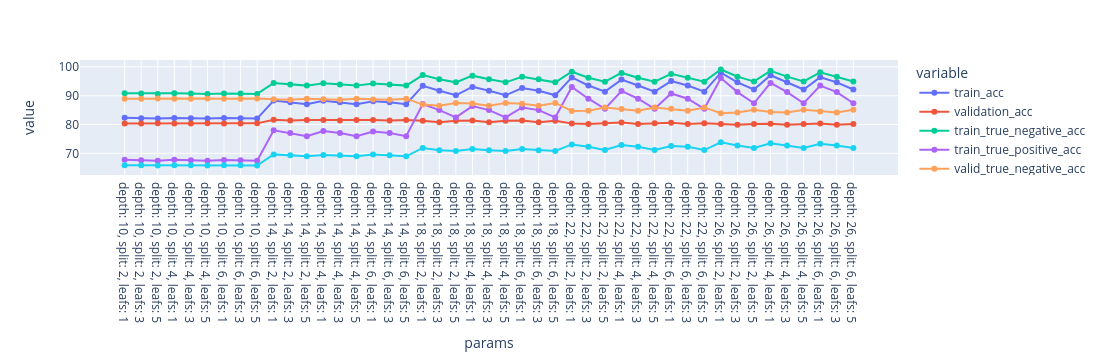

CPU times: user 1min 19s, sys: 406 ms, total: 1min 19s
Wall time: 1min 16s


In [15]:
%%time

random_state = 7412395
n_components = 21
prcomp = PCA(n_components=n_components, random_state=random_state).fit(x_train)

pc_train_pre = prcomp.transform(x_train)
pc_validation_pre = prcomp.transform(x_validation)
pc_test_pre  = prcomp.transform(x_test)

n=n_components

columns = ['cp'+str(x+1) for x in list(range(n))]

pc_train = pd.DataFrame(pc_train_pre[:,:n], columns = columns)
pc_validation = pd.DataFrame(pc_validation_pre[:,:n], columns = columns)
pc_test  = pd.DataFrame(pc_test_pre[:,:n], columns = columns)

params = {'max_depth': [10,14,18,22,26],
         'min_samples_split': [2,4,6],
         'min_samples_leaf': [1,3,5]}

calculate_tree_stats_pre_pruning(params, pc_train, y_train, pc_validation, y_validation);

Vemos que para profundidades 18, 22 e 26, temos bons dados de acurácia nos verdadeiros positivos, embora com uma ligeira queda nos dados de verdadeiros negativos e um indicativo de overfitting através da acurácia geral de treino. 

Vamos refinar os parâmetros em busca de melhores resultados:

100%|██████████| 5/5 [01:24<00:00, 17.00s/it]


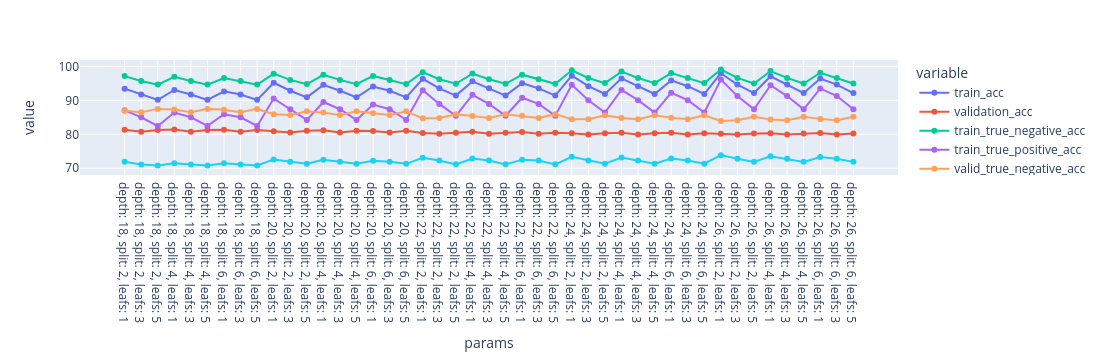

In [16]:
params = {'max_depth': [18,20,22,24,26],
         'min_samples_split': [2,4,6],
         'min_samples_leaf': [1,3,5]}

calculate_tree_stats_pre_pruning(params, pc_train, y_train, pc_validation, y_validation);

100%|██████████| 6/6 [01:44<00:00, 17.44s/it]


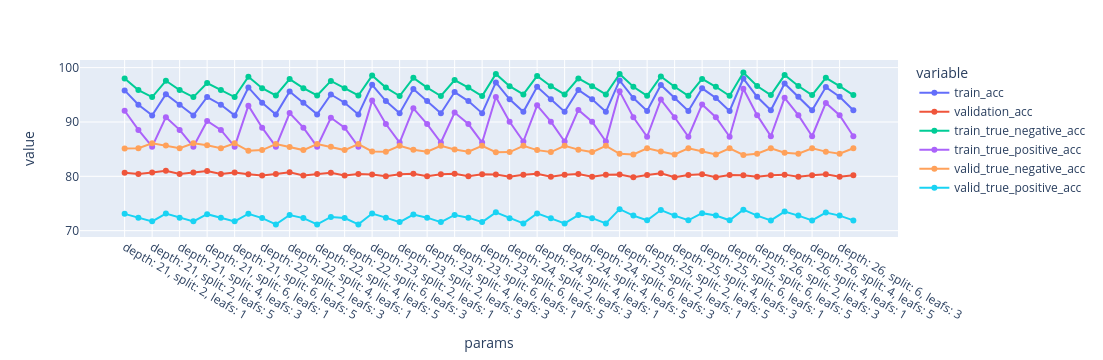

In [17]:
params = {'max_depth': [21,22,23,24,25,26],
         'min_samples_split': [2,4,6],
         'min_samples_leaf': [1,3,5]}

calculate_tree_stats_pre_pruning(params, pc_train, y_train, pc_validation, y_validation);

100%|██████████| 4/4 [01:11<00:00, 17.82s/it]


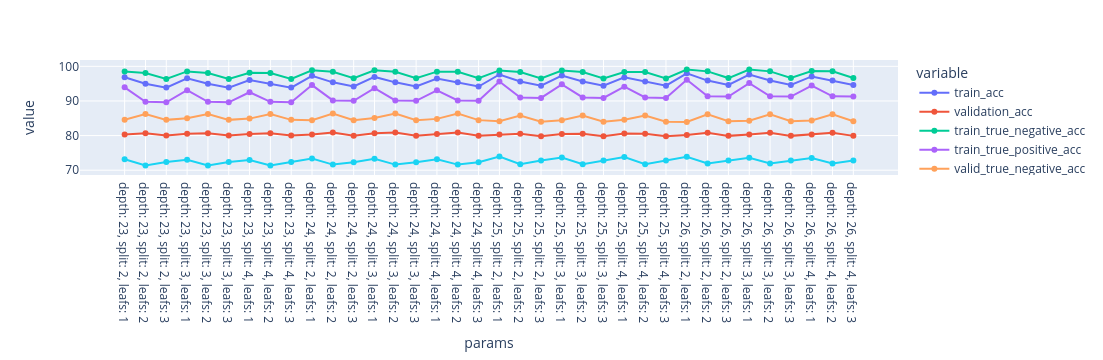

In [18]:
params = {'max_depth': [23,24,25,26],
         'min_samples_split': [2,3,4],
         'min_samples_leaf': [1,2,3]}

calculate_tree_stats_pre_pruning(params, pc_train, y_train, pc_validation, y_validation);

Após algumas iterações, obtivemos um melhor resultado para verdadeiros negativos com os seguintes parâmetros: 
- max_depth: 25
- min_samples_split: 2
- min_samples_leaf: 1

Vamos utilizar esses parâmetros e continuar para nossa pós poda:

In [19]:
%%time

# Getting ccp_alphas
clf_post = DecisionTreeClassifier(random_state=7412395, max_depth=25, min_samples_split=2, min_samples_leaf=1)
path = clf_post.cost_complexity_pruning_path(pc_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Granting ccp_alphas are unique and positive
ccp_alphas = np.unique(ccp_alphas[ccp_alphas >= 0])


# Creating the new tree
clf_post_new = DecisionTreeClassifier(random_state=7412395)

# Creating the grid params with 1 ccp_alpha for each 10 in the list
grid_params = {'ccp_alpha': ccp_alphas[::10]}

# Avaliating ccp_alphas using Grid Search
grid = GridSearchCV(estimator = clf_post_new, param_grid = grid_params, cv=10, n_jobs=-1)
grid.fit(pc_validation, y_validation)

# Adding results to a dataframe
results = pd.DataFrame(grid.cv_results_)

CPU times: user 7.49 s, sys: 1.2 s, total: 8.69 s
Wall time: 3min 10s


Modelo pré-poda:

Acurácia na base de treino: 97.64%
Acurácia na base de teste: 80.01%


Acurácias de treino:
Modelo previu cancelado, mas é não cancelado: 1.18%
Modelo previu não cancelado, e é não cancelado: 98.82%
Modelo previu não cancelado, mas é cancelado: 4.37%
Modelo previu cancelado, e é cancelado: 95.63%


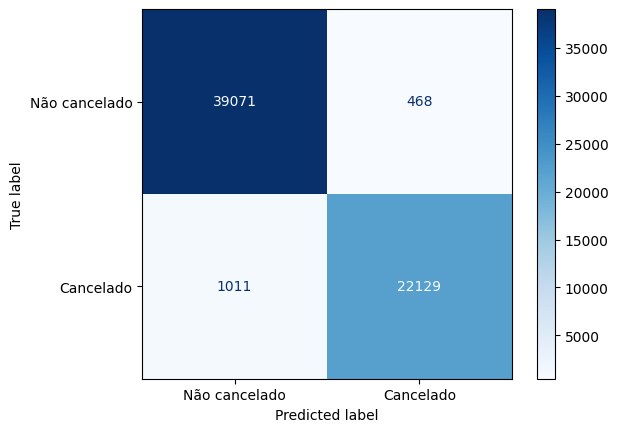

Acurácias de teste:
Modelo previu cancelado, mas é não cancelado: 15.43%
Modelo previu não cancelado, e é não cancelado: 84.57%
Modelo previu não cancelado, mas é cancelado: 27.70%
Modelo previu cancelado, e é cancelado: 72.30%


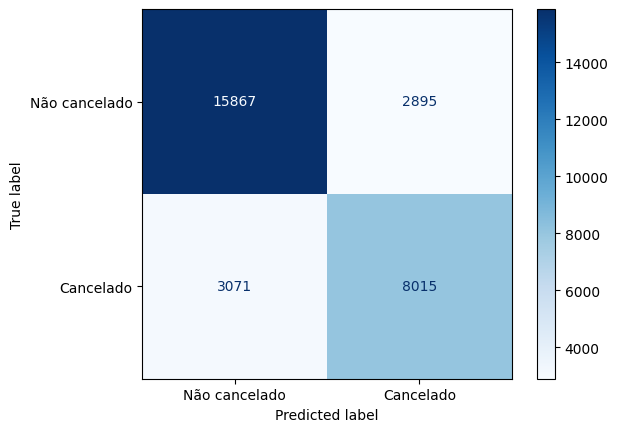

Modelo pós-poda:

Acurácia na base de treino: 81.54%
Acurácia na base de teste: 80.65%


Acurácias de treino:
Modelo previu cancelado, mas é não cancelado: 9.39%
Modelo previu não cancelado, e é não cancelado: 90.61%
Modelo previu não cancelado, mas é cancelado: 33.95%
Modelo previu cancelado, e é cancelado: 66.05%


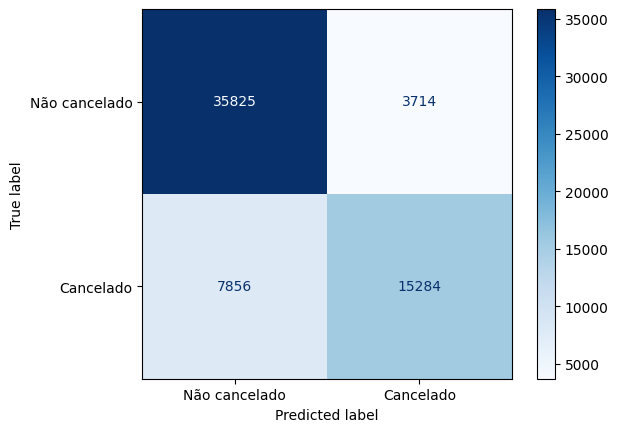

Acurácias de teste:
Modelo previu cancelado, mas é não cancelado: 9.90%
Modelo previu não cancelado, e é não cancelado: 90.10%
Modelo previu não cancelado, mas é cancelado: 35.34%
Modelo previu cancelado, e é cancelado: 64.66%


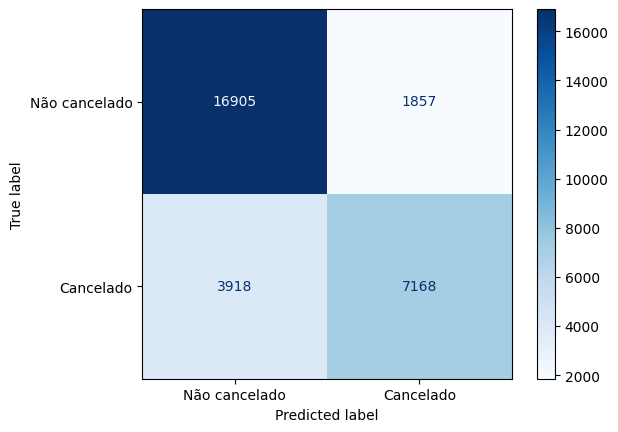

[81.54086695703505,
 80.65196998123827,
 90.60674270972964,
 66.05012964563525,
 90.10233450591622,
 64.65812736785135]

In [20]:
# Getting the best ccp_alpha
best_ccp = results.iloc[grid.best_index_,4]

# Training a tree with the best ccp_alpha
model_pre_prun = DecisionTreeClassifier(random_state=7412395, max_depth=25, min_samples_split=2, min_samples_leaf=1).fit(pc_train, y_train)
model_post_prun = DecisionTreeClassifier(random_state=7412395, ccp_alpha=best_ccp, max_depth=25, min_samples_split=2, min_samples_leaf=1).fit(pc_train, y_train)

print('Modelo pré-poda:\n')
calculate_model_acc_score(model_pre_prun, pc_train, y_train, pc_test, y_test, show_acc=True, show_confusion_matrix=True)

print('Modelo pós-poda:\n')
calculate_model_acc_score(model_post_prun, pc_train, y_train, pc_test, y_test, show_acc=True, show_confusion_matrix=True)

Embora a acurácia geral na base de teste tenha melhorado e o overfit à base de treino tenha diminuído no modelo com a pós-poda, esse modelo não está prevendo muito bem os cancelamentos, com uma taxa de 64,66% contra 72,30% do nosso modelo somente com a pré-poda.

## 5. Outros ajustes<a name="5"></a> 

Como vimos ao modelar nossa árvore de decisão, é possível que o desbalanceamento dos dados esteja prejudicando nossa acurácia de cancelamentos. Vamos calcular o modelo encontrado com o balanceamento aplicado:

Modelo pré-poda:

Acurácia na base de treino: 97.54%
Acurácia na base de teste: 80.03%


Acurácias de treino:
Modelo previu cancelado, mas é não cancelado: 2.83%
Modelo previu não cancelado, e é não cancelado: 97.17%
Modelo previu não cancelado, mas é cancelado: 1.82%
Modelo previu cancelado, e é cancelado: 98.18%


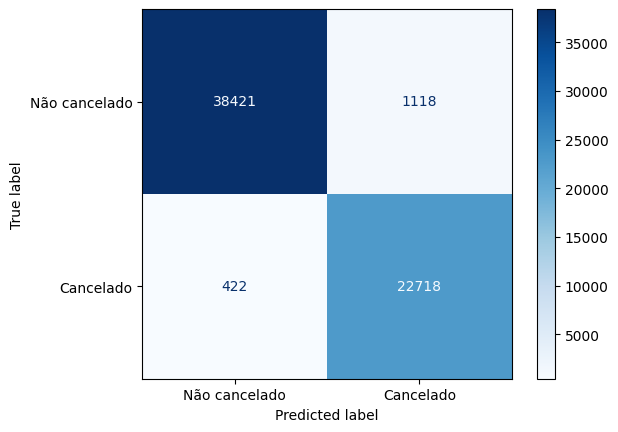

Acurácias de teste:
Modelo previu cancelado, mas é não cancelado: 16.82%
Modelo previu não cancelado, e é não cancelado: 83.18%
Modelo previu não cancelado, mas é cancelado: 25.29%
Modelo previu cancelado, e é cancelado: 74.71%


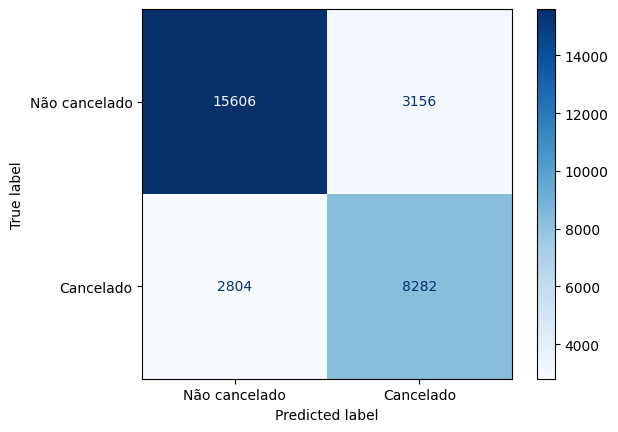

Modelo pós-poda:

Acurácia na base de treino: 80.89%
Acurácia na base de teste: 80.03%


Acurácias de treino:
Modelo previu cancelado, mas é não cancelado: 14.39%
Modelo previu não cancelado, e é não cancelado: 85.61%
Modelo previu não cancelado, mas é cancelado: 27.18%
Modelo previu cancelado, e é cancelado: 72.82%


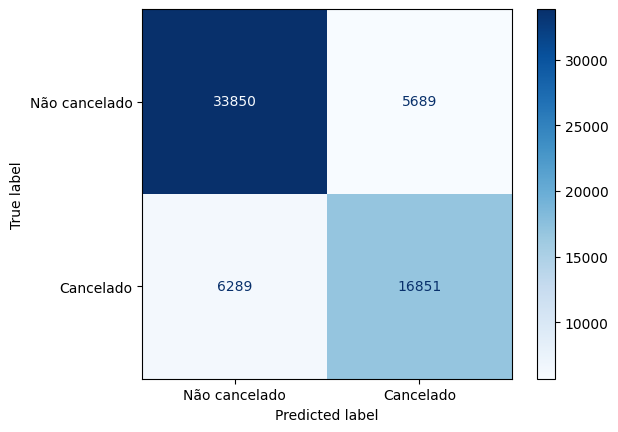

Acurácias de teste:
Modelo previu cancelado, mas é não cancelado: 14.88%
Modelo previu não cancelado, e é não cancelado: 85.12%
Modelo previu não cancelado, mas é cancelado: 28.60%
Modelo previu cancelado, e é cancelado: 71.40%


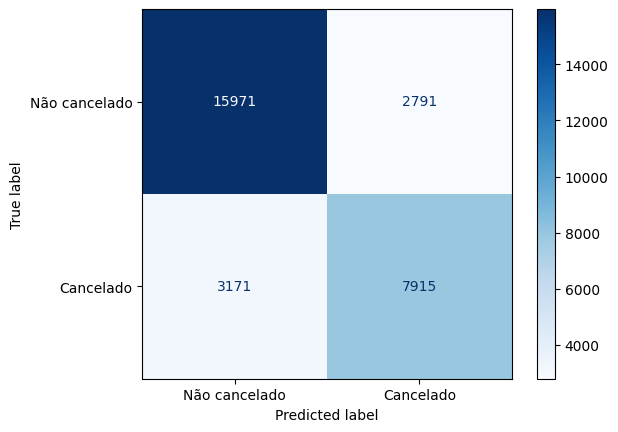

[80.8899312369374,
 80.02546234253552,
 85.6116745491793,
 72.82195332757131,
 85.12418718686708,
 71.3963557640267]

In [21]:
# Training a tree with the best ccp_alpha
model_pre_prun = DecisionTreeClassifier(random_state=7412395, max_depth=25, min_samples_split=2, min_samples_leaf=1, class_weight='balanced').fit(pc_train, y_train)
model_post_prun = DecisionTreeClassifier(random_state=7412395, ccp_alpha=best_ccp, max_depth=25, min_samples_split=2, min_samples_leaf=1, class_weight='balanced').fit(pc_train, y_train)

print('Modelo pré-poda:\n')
calculate_model_acc_score(model_pre_prun, pc_train, y_train, pc_test, y_test, show_acc=True, show_confusion_matrix=True)

print('Modelo pós-poda:\n')
calculate_model_acc_score(model_post_prun, pc_train, y_train, pc_test, y_test, show_acc=True, show_confusion_matrix=True)

Ao balancear, já conseguimos melhorar a acurácia do cancelamento da pós-poda de 64,66% para 71,40%. O modelo de pré-poda também teve uma melhora, indo de 72,3% para 74,71%.

Quando modelamos as nossas árvores, também treinamos o modelo em cima das bases de treino e validação juntas. Vamos fazer o mesmo aqui e verificar se existe alguma melhora:

Modelo pré-poda:

Acurácia na base de treino: 97.21%
Acurácia na base de teste: 81.08%


Acurácias de treino:
Modelo previu cancelado, mas é não cancelado: 3.35%
Modelo previu não cancelado, e é não cancelado: 96.65%
Modelo previu não cancelado, mas é cancelado: 1.84%
Modelo previu cancelado, e é cancelado: 98.16%


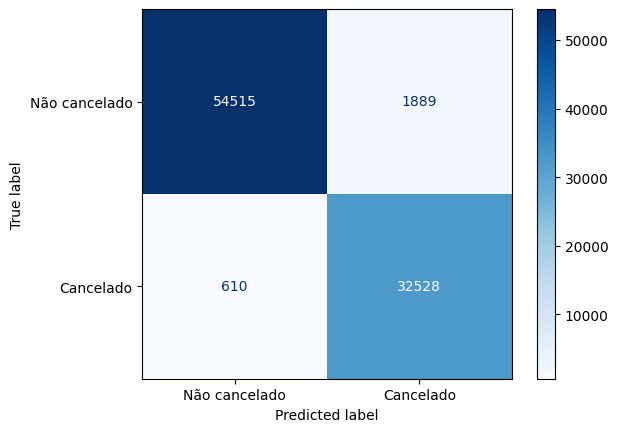

Acurácias de teste:
Modelo previu cancelado, mas é não cancelado: 16.31%
Modelo previu não cancelado, e é não cancelado: 83.69%
Modelo previu não cancelado, mas é cancelado: 23.32%
Modelo previu cancelado, e é cancelado: 76.68%


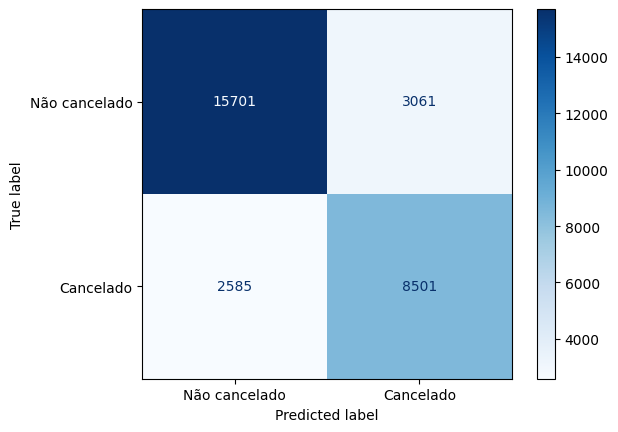

Modelo pós-poda:

Acurácia na base de treino: 80.15%
Acurácia na base de teste: 79.47%


Acurácias de treino:
Modelo previu cancelado, mas é não cancelado: 15.71%
Modelo previu não cancelado, e é não cancelado: 84.29%
Modelo previu não cancelado, mas é cancelado: 26.91%
Modelo previu cancelado, e é cancelado: 73.09%


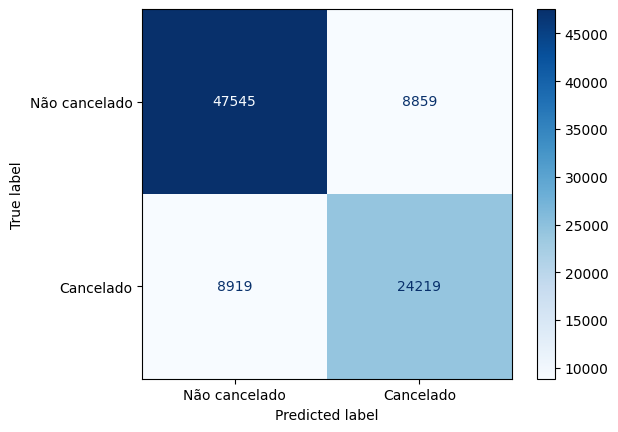

Acurácias de teste:
Modelo previu cancelado, mas é não cancelado: 16.18%
Modelo previu não cancelado, e é não cancelado: 83.82%
Modelo previu não cancelado, mas é cancelado: 27.88%
Modelo previu cancelado, e é cancelado: 72.12%


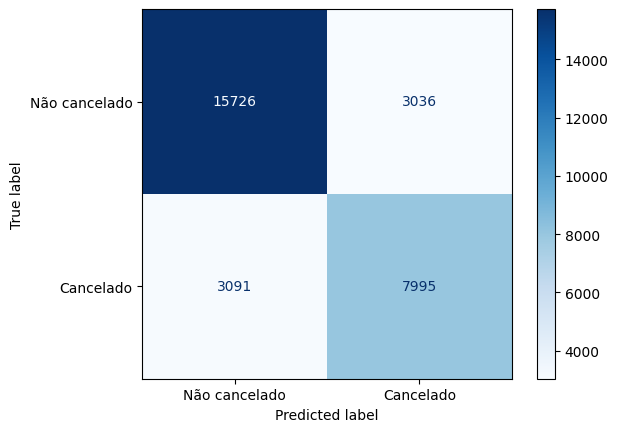

[80.1456299836948,
 79.47266148485662,
 84.2936671158074,
 73.08527973927214,
 83.81835625199872,
 72.11798664982861]

In [22]:
pc_train_validation = pd.concat([pc_train, pc_validation])
y_train_validation = pd.concat([y_train, y_validation])

# Training a tree with the best ccp_alpha
model_pre_prun = DecisionTreeClassifier(random_state=7412395, max_depth=25, min_samples_split=2, min_samples_leaf=1, class_weight='balanced').fit(pc_train_validation, y_train_validation)
model_post_prun = DecisionTreeClassifier(random_state=7412395, ccp_alpha=best_ccp, max_depth=25, min_samples_split=2, min_samples_leaf=1, class_weight='balanced').fit(pc_train_validation, y_train_validation)

print('Modelo pré-poda:\n')
calculate_model_acc_score(model_pre_prun, pc_train_validation, y_train_validation, pc_test, y_test, show_acc=True, show_confusion_matrix=True)

print('Modelo pós-poda:\n')
calculate_model_acc_score(model_post_prun, pc_train_validation, y_train_validation, pc_test, y_test, show_acc=True, show_confusion_matrix=True)

A acurácia de verdadeiros positivos melhorou para os dois modelos: 
- Pré-poda: 74,71% -> 76,68%
- Pré-poda + Pós-poda: 71,4% -> 72,12%

Infelizmente, as acurácias ainda não estão melhores do que na árvore sem PCA (conseguimos uma acurácia na base de teste de 78,73% de verdadeiros positivos). 

Isso pode estar ocorrendo devido ao peso de cada variável nas componentes e na capacidade de rotular corretamente as linhas com cancelamento, pois aqui estamos utilizando combinações de todas as variáveis.

Vamos testar essa possibilidade realizando todos os passos que fizemos até aqui, porém apenas para as principais variáveis que definimos no modelo de árvores sem PCA. Seremos mais diretos:

In [23]:
main_dummies_best = main_dummies[[
    'lead_time',                         
    'previous_cancellations',            
    'total_of_special_requests',         
    'customer_type_Transient',           
    'adr',                               
    'agent',                             
    'market_segment_Groups',             
    'assigned_room_type',                
    'arrival_date_week_number',          
    'market_segment_Online TA',          
    'required_car_parking_spaces',       
    'arrival_date_day_of_month',         
    'stays_in_week_nights',              
    'previous_bookings_not_canceled',    
    'booking_changes',                   
    'arrival_date_year',                 
    'reserved_room_type',
    'is_canceled'
]]

X = main_dummies_best.drop('is_canceled', axis=1)
y = main_dummies_best.is_canceled

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7412395)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.3, random_state=7412395)

In [24]:
%%time
stats_list = []
for n_components in tqdm(range(5, 16)):
    stats = train_tree_with_pca(
        n_components, 
        x_train, 
        x_validation, 
        x_test, 
        y_train, 
        y_validation, 
        y_test, 
        random_state=7412395, 
        show_accuracy=False, 
        plot_matrix=False
    )
    stats_list.append(stats)

stats_df = pd.DataFrame(stats_list, columns=[
    'n_components', 
    'train_acc', 
    'validation_acc',
    'test_true_negative_acc', 
    'test_true_positive_acc', 
    'valid_true_negative_acc',
    'valid_true_positive_acc'
])

100%|██████████| 11/11 [00:13<00:00,  1.22s/it]

CPU times: user 30.8 s, sys: 2.23 s, total: 33 s
Wall time: 13.5 s


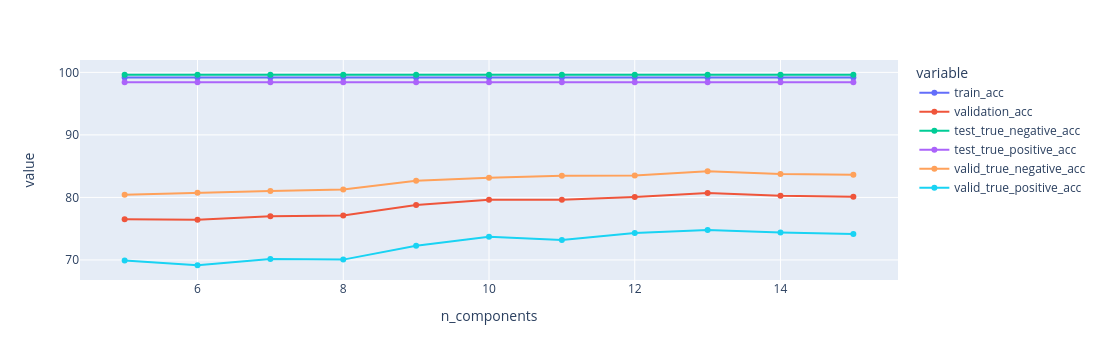

In [25]:
px.line(
    x='n_components', 
    y=[
        'n_components', 
        'train_acc', 
        'validation_acc', 
        'test_true_negative_acc', 
        'test_true_positive_acc', 
        'valid_true_negative_acc',
        'valid_true_positive_acc'
    ], 
    data_frame=stats_df, 
    markers=True
)

100%|██████████| 5/5 [00:47<00:00,  9.55s/it]


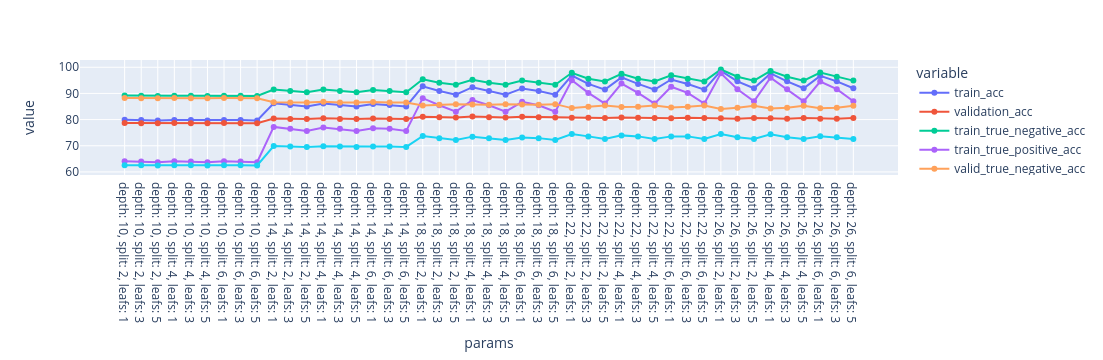

CPU times: user 49.7 s, sys: 189 ms, total: 49.8 s
Wall time: 48.1 s


In [26]:
%%time

random_state = 7412395
n_components = 13
prcomp = PCA(n_components=n_components, random_state=random_state).fit(x_train)

pc_train_pre = prcomp.transform(x_train)
pc_validation_pre = prcomp.transform(x_validation)
pc_test_pre  = prcomp.transform(x_test)

n=n_components

columns = ['cp'+str(x+1) for x in list(range(n))]

pc_train = pd.DataFrame(pc_train_pre[:,:n], columns = columns)
pc_validation = pd.DataFrame(pc_validation_pre[:,:n], columns = columns)
pc_test  = pd.DataFrame(pc_test_pre[:,:n], columns = columns)

params = {'max_depth': [10,14,18,22,26],
         'min_samples_split': [2,4,6],
         'min_samples_leaf': [1,3,5]}

calculate_tree_stats_pre_pruning(params, pc_train, y_train, pc_validation, y_validation);

100%|██████████| 4/4 [00:42<00:00, 10.50s/it]


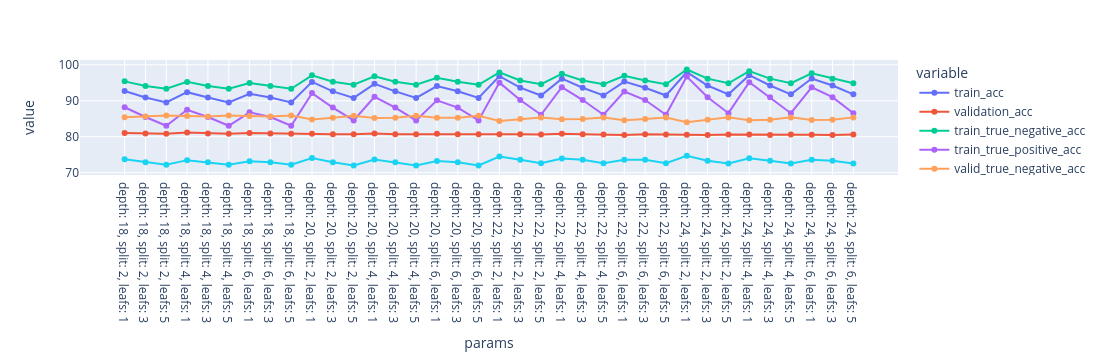

In [27]:
params = {'max_depth': [18,20,22,24],
         'min_samples_split': [2,4,6],
         'min_samples_leaf': [1,3,5]}

calculate_tree_stats_pre_pruning(params, pc_train, y_train, pc_validation, y_validation);

100%|██████████| 4/4 [00:42<00:00, 10.74s/it]


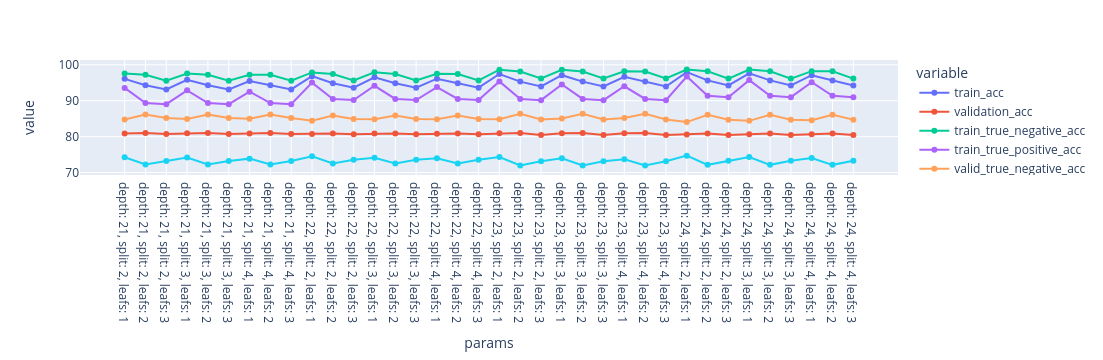

In [28]:
params = {'max_depth': [21,22,23,24],
        'min_samples_split': [2,3,4],
        'min_samples_leaf': [1,2,3]}

calculate_tree_stats_pre_pruning(params, pc_train, y_train, pc_validation, y_validation);

In [29]:
%%time

# Getting ccp_alphas
clf_post = DecisionTreeClassifier(random_state=7412395, max_depth=24, min_samples_split=2, min_samples_leaf=1)
path = clf_post.cost_complexity_pruning_path(pc_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Granting ccp_alphas are unique and positive
ccp_alphas = np.unique(ccp_alphas[ccp_alphas >= 0])


# Creating the new tree
clf_post_new = DecisionTreeClassifier(random_state=7412395)

# Creating the grid params with 1 ccp_alpha for each 10 in the list
grid_params = {'ccp_alpha': ccp_alphas[::10]}

# Avaliating ccp_alphas using Grid Search
grid = GridSearchCV(estimator = clf_post_new, param_grid = grid_params, cv=5, n_jobs=-1)
grid.fit(pc_validation, y_validation)

# Adding results to a dataframe
results = pd.DataFrame(grid.cv_results_)

CPU times: user 4.27 s, sys: 752 ms, total: 5.03 s
Wall time: 54.2 s


Modelo pré-poda:

Acurácia na base de treino: 96.52%
Acurácia na base de teste: 80.89%


Acurácias de treino:
Modelo previu cancelado, mas é não cancelado: 4.43%
Modelo previu não cancelado, e é não cancelado: 95.57%
Modelo previu não cancelado, mas é cancelado: 1.87%
Modelo previu cancelado, e é cancelado: 98.13%


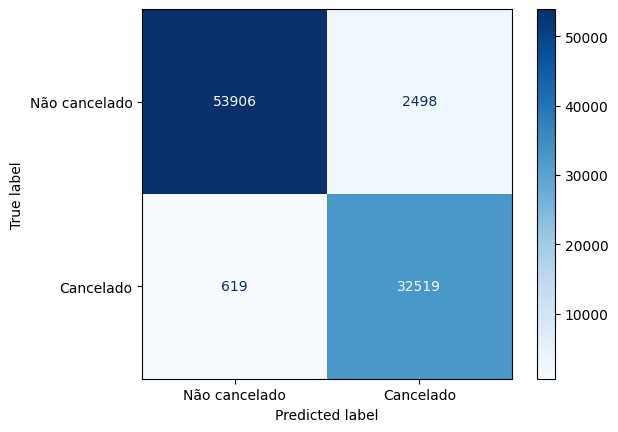

Acurácias de teste:
Modelo previu cancelado, mas é não cancelado: 17.03%
Modelo previu não cancelado, e é não cancelado: 82.97%
Modelo previu não cancelado, mas é cancelado: 22.61%
Modelo previu cancelado, e é cancelado: 77.39%


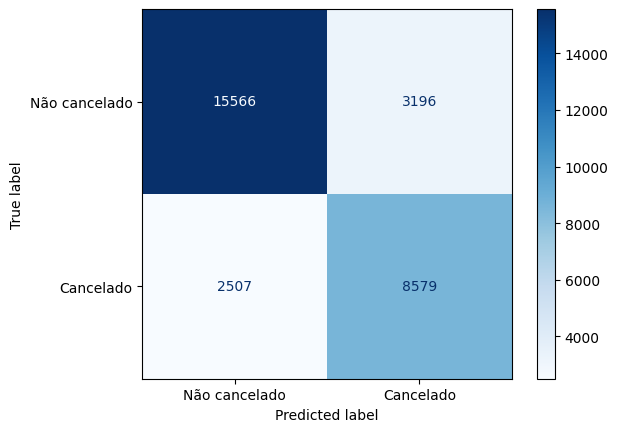

Modelo pós-poda:

Acurácia na base de treino: 77.86%
Acurácia na base de teste: 77.56%


Acurácias de treino:
Modelo previu cancelado, mas é não cancelado: 22.85%
Modelo previu não cancelado, e é não cancelado: 77.15%
Modelo previu não cancelado, mas é cancelado: 20.94%
Modelo previu cancelado, e é cancelado: 79.06%


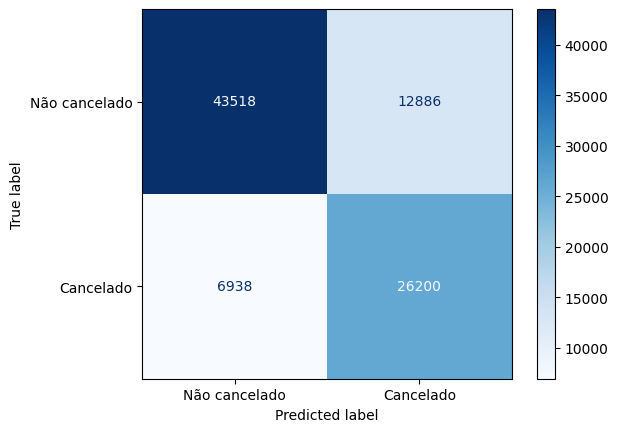

Acurácias de teste:
Modelo previu cancelado, mas é não cancelado: 22.66%
Modelo previu não cancelado, e é não cancelado: 77.34%
Modelo previu não cancelado, mas é cancelado: 22.08%
Modelo previu cancelado, e é cancelado: 77.92%


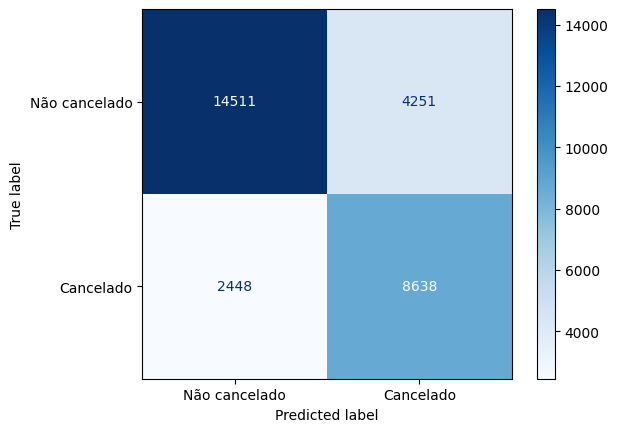

[77.86066873645888,
 77.5562851782364,
 77.15410254591873,
 79.0633110024745,
 77.34250079948832,
 77.91809489446149]

In [30]:
pc_train_validation = pd.concat([pc_train, pc_validation])
y_train_validation = pd.concat([y_train, y_validation])

# Getting the best ccp_alpha
best_ccp = results.iloc[grid.best_index_,4]

# Training a tree with the best ccp_alpha
model_pre_prun = DecisionTreeClassifier(random_state=7412395, max_depth=24, min_samples_split=2, min_samples_leaf=1, class_weight='balanced').fit(pc_train_validation, y_train_validation)
model_post_prun = DecisionTreeClassifier(random_state=7412395, ccp_alpha=best_ccp, max_depth=24, min_samples_split=2, min_samples_leaf=1, class_weight='balanced').fit(pc_train_validation, y_train_validation)

print('Modelo pré-poda:\n')
calculate_model_acc_score(model_pre_prun, pc_train_validation, y_train_validation, pc_test, y_test, show_acc=True, show_confusion_matrix=True)

print('Modelo pós-poda:\n')
calculate_model_acc_score(model_post_prun, pc_train_validation, y_train_validation, pc_test, y_test, show_acc=True, show_confusion_matrix=True)

## 6. Conclusão<a name="6"></a>

Com as variáveis mais importantes encontradas anteriormente e utilizando PCA + podas, obtivemos uma melhora para as acurácias de cancelamentos com relação aos modelos em que utilizávamos todas as variáveis:

- Pré-poda somente: 76,68% -> 77.39%
- Pré-poda + pós-poda: 72,12% -> 77.92%

Chegamos bem próximo da acurácia encontrada somente com as árvores: 78.73%. No entanto, a acurácia geral (e consequentemente a de verdadeiros negativos) caiu muito. As nossas acurácias obtidas sem PCA foram:
- Acurácia geral no teste: 81.28%
- Acurácia verdadeiros negativos: 82.79%

E utilizando PCA com pré-poda e pós-poda:
- Pré-poda somente: geral - 80.89%, verdadeiro negativo - 82.97%
- Pré-poda + pós-poda: geral - 77.56%, verdadeiro negativo - 77.34%

Ou seja, apesar de termos chegado bem próximo dos resultados anteriores, continuamos sem grandes melhorias após utilizar a técnica de PCA. Isso pode ter ocorrido porque tínhamos poucas variáveis no nosso conjunto de dados, o que viabilizou computacionalmente a criação de modelos sem a aplicação da técnica.

Aplicar PCA pode fazer mais sentido quando tivermos 200 ou mais parâmetros, mas com 50, acabou não sendo necessário.

Vamos encerrar por aqui esse caderno, porém no próximo iremos continuar nossa busca pelas melhores acurácias, dessa vez utilizando a técnica SVM (Support Vector Machines).

O próximo caderno pode ser acessado aqui: link